# Table of Contents
- [Imports](#imports)
- [Preprocessing](#preprocessing)
  - [Observing statistics of dataset](#observing-statistics-of-dataset)
    - [No of unique features](#no-of-unique-features)
    - [Visualization](#visualization)
    - [Split data](#split-data)
- [Basic CatBoost Model](#basic-catboost-model)
- [Firefly Algorithm Definition](#firefly-algorithm-definition)
- [Best Model Hyperparameters Obtained](#best-model-hyperparameters-obtained)
- [K-Fold Validation](#k-fold-validation)


# Imports

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Machine Learning & Optimization
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import math


In [2]:
def score(actual_values, predicted_values):
    mae_score = mean_absolute_error(actual_values, predicted_values)
    R2_score = r2_score(actual_values,predicted_values)
    RMSE = math.sqrt(mean_squared_error(actual_values,predicted_values))
    return {"MAE":mae_score, "R2_score":R2_score, "RMSE":RMSE}



# Preprocessing

In [3]:
# Step 2: Load dataset
data_filepath = r"Wiley.csv"

data = pd.read_csv(data_filepath)
# remove
data = data.drop(['Index','Unnamed: 16'], axis=1)
print(data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement (kg/m3)  785 non-null    float64
 1   SF (kg/m3)      785 non-null    float64
 2   BFS (kg/m3)     785 non-null    float64
 3   FA (kg/m3)      785 non-null    float64
 4   QP (kg/m3)      785 non-null    float64
 5   LSP (kg/m3)     785 non-null    float64
 6   NS (kg/m3)      785 non-null    float64
 7   Fiber (kg/m3)   785 non-null    float64
 8   Sand (kg/m3)    785 non-null    float64
 9   Gravel (kg/m3)  785 non-null    int64  
 10  Water (kg/m3)   785 non-null    float64
 11  SP (kg/m3)      785 non-null    float64
 12  T (oC)          785 non-null    int64  
 13  RH (%)          785 non-null    int64  
 14  Age (days)      785 non-null    int64  
 15  fc (MPa)        785 non-null    float64
dtypes: float64(12), int64(4)
memory usage: 98.3 KB
None


## Observing statistics of dataset

In [10]:
# Create DataFrame
data_copy = data.copy()

# Generate statistical description
stats_description = data_copy.describe().T

# Additional stats: Kurtosis and Skewness
stats_description['Kurtosis'] = data_copy.kurtosis()
stats_description['Skewness'] = data_copy.skew()

print(stats_description)
stats_description.to_csv('stats_description.csv')


                count         mean         std    min    25%     50%      75%  \
Cement (kg/m3)  785.0   740.435694  163.851965  270.0  630.0   776.0   850.00   
SF (kg/m3)      785.0   136.916051  105.179304    0.0   43.7   144.0   220.00   
BFS (kg/m3)     785.0    25.079745   74.614233    0.0    0.0     0.0     0.00   
FA (kg/m3)      785.0    26.421146   67.220609    0.0    0.0     0.0     0.00   
QP (kg/m3)      785.0    31.595541   75.578987    0.0    0.0     0.0     0.00   
LSP (kg/m3)     785.0    33.571592   99.347944    0.0    0.0     0.0     0.00   
NS (kg/m3)      785.0     3.524433    7.353852    0.0    0.0     0.0     4.00   
Fiber (kg/m3)   785.0    55.047134   73.691184    0.0    0.0     0.0   156.00   
Sand (kg/m3)    785.0  1002.492611  280.131847    0.0  787.1  1036.0  1231.00   
Gravel (kg/m3)  785.0   151.670064  354.392995    0.0    0.0     0.0     0.00   
Water (kg/m3)   785.0   179.134803   23.691038   90.0  163.0   177.0   189.00   
SP (kg/m3)      785.0    30.

### No of unique features

In [5]:
print(data.nunique())

Cement (kg/m3)     99
SF (kg/m3)         61
BFS (kg/m3)        20
FA (kg/m3)         22
QP (kg/m3)         14
LSP (kg/m3)        15
NS (kg/m3)         22
Fiber (kg/m3)       9
Sand (kg/m3)      106
Gravel (kg/m3)     21
Water (kg/m3)      48
SP (kg/m3)         71
T (oC)              6
RH (%)              6
Age (days)          9
fc (MPa)          622
dtype: int64


### Visualization

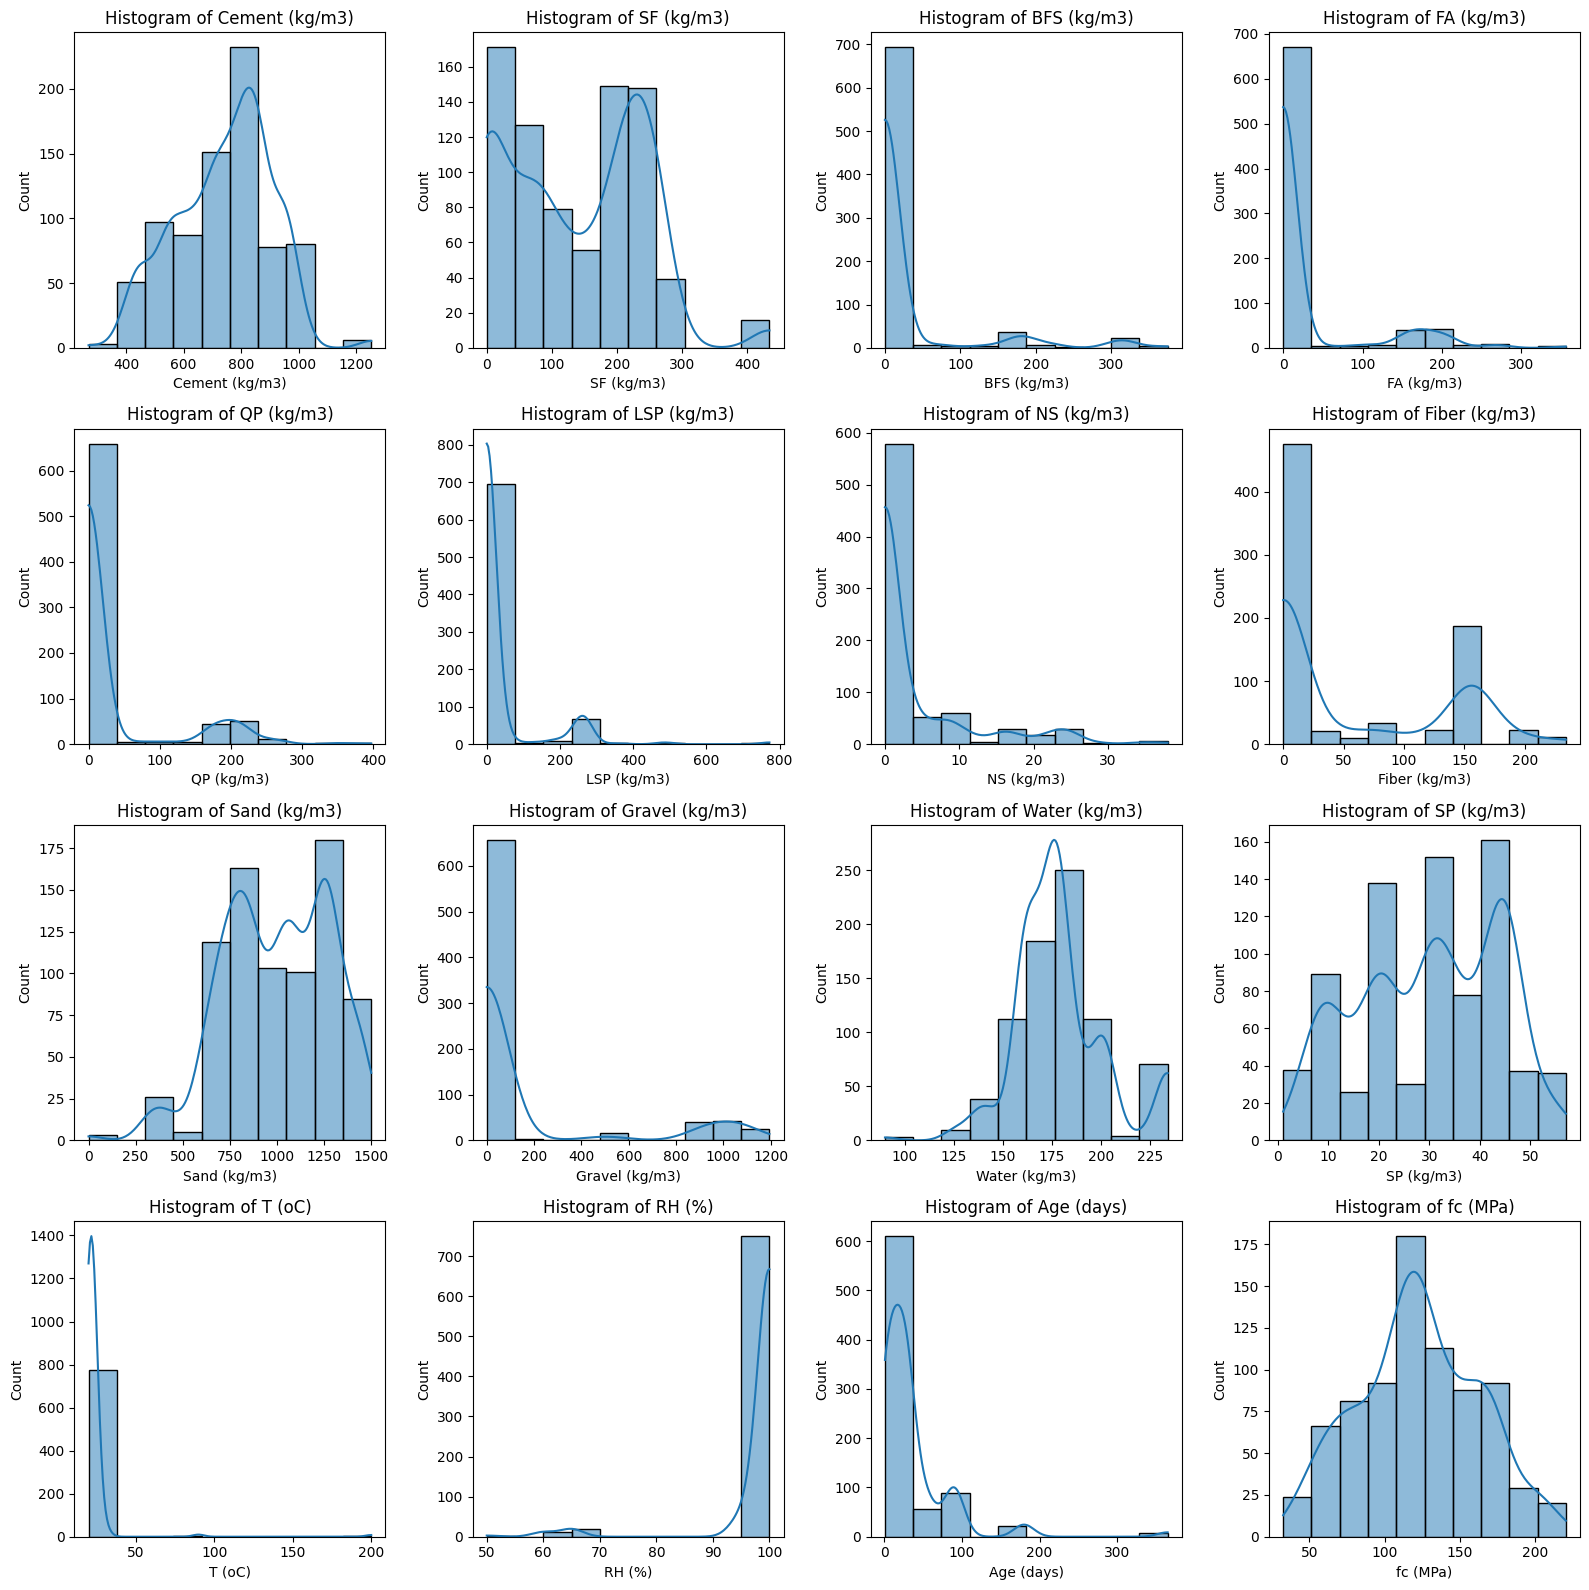

In [4]:
# Get number of numerical columns
num_cols = data.shape[1]  # Since all columns are numerical

# Determine grid size for subplots
rows = math.ceil(num_cols / 4)  # Adjust 3 to change number of columns per row
cols = min(num_cols, 4)  # Keep at most 3 columns per row

# Set figure size dynamically
plt.figure(figsize=(cols * 4, rows * 4))

# Loop through columns and plot histograms
for i, col in enumerate(data.columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(data[col], bins=10, kde=True)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()


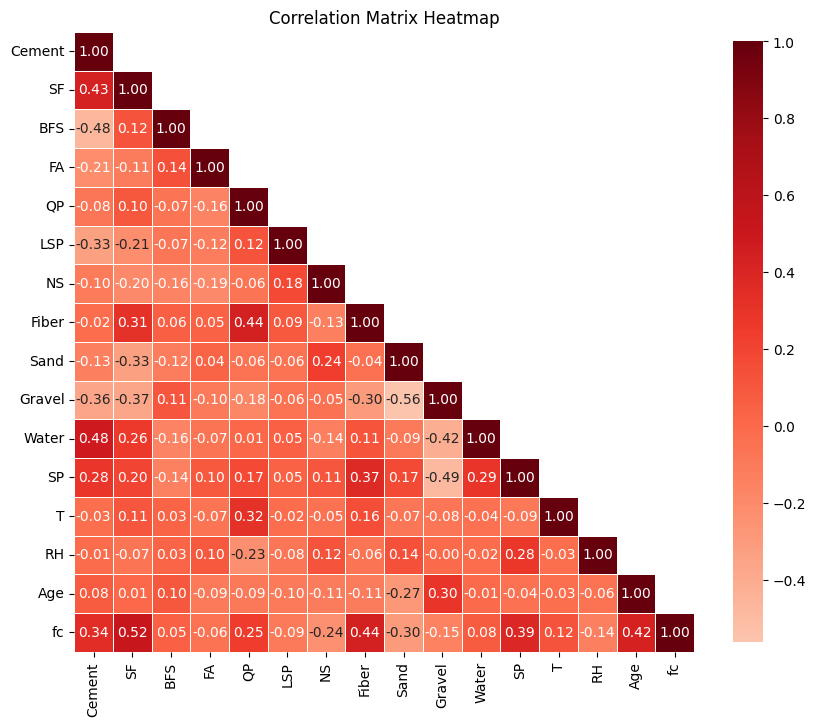

In [ ]:
data_copy = data.copy()
for col in data_copy.columns:
    col_name = col.split()[0] 
    data_copy.rename(columns={col: col_name}, inplace=True)

# Calculate correlation matrix
corr_matrix = data_copy.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Create the heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5, square=True, center=0, mask=mask, cbar_kws={'shrink': 0.65})
plt.title('Correlation Matrix Heatmap')
plt.show()


### Split data

In [4]:
X = data.drop('fc (MPa)', axis=1)  # Replace 'fc (MPa)' with your target column name
y = data['fc (MPa)']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Basic Catboost model

In [ ]:
basic_model = CatBoostRegressor(verbose=0)
basic_model.fit(X_train,y_train)

basic_model_predictions = basic_model.predict(X_valid)
print(score(y_valid, basic_model_predictions))

{'MAE': 4.842734419072415, 'R2_score': 0.9737849671809723, 'MSE': 41.05255258637776}


In [ ]:
basic_model_predictions_train = basic_model.predict(X_train)
print(score(y_train, basic_model_predictions_train))

{'MAE': 2.738650005987045, 'R2_score': 0.9899561251353487, 'MSE': 16.256196391255017}


# Firefly algorithm definition

In [8]:
def initialize_fireflies(population_size, dimension):
  fireflies = np.zeros((population_size, dimension))
  for i in range(population_size):
    for j in range(dimension):
      fireflies[i][j] = np.random.uniform(param_bounds[j][0],param_bounds[j][1])
      # make sure that depth, border_count and iterations are integers
      if j == 1 or j==5 or j==6:
        fireflies[i][j] = round(fireflies[i][j])
  return fireflies

def objective_function(solution):

    learning_rate = solution[0]
    if learning_rate < 0.01: 
        learning_rate = 0.01
    elif learning_rate > 0.05:
        learning_rate = 0.05

    depth = int(solution[1])
    if depth < 4: 
        depth = 4
    elif depth > 10:
        depth = 10

    l2_leaf_reg = solution[2]
    if l2_leaf_reg < 0.01: 
        l2_leaf_reg = 0.01
    elif l2_leaf_reg > 100:
        l2_leaf_reg = 100

    bagging_temperature = solution[3]
    if bagging_temperature < 0: 
        bagging_temperature = 0
    elif bagging_temperature > 10:
        bagging_temperature = 10

    subsample = solution[4]
    if subsample < 0.5: 
        subsample = 0.5
    elif subsample > 0.8:
        subsample = 0.8

    border_count = int(solution[5])
    if border_count < 1:
        border_count = 1
    elif border_count > 255:
        border_count = 255

    iterations = int(solution[6])
    if iterations < 100:
        iterations = 100
    elif iterations > 1500:
        iterations = 1500
    
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        border_count=border_count,
        iterations=iterations,
        verbose=0
    )

    # Fit the model on the training data with early stopping based on validation data
    model.fit(X_train,y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_valid)

    # Calculate and print the performance using mean squared error (MSE)
    MSE = mean_squared_error(y_valid,y_pred)
    return MSE

def calculate_intensity(population, objective_func):
    return np.array([objective_func(ind) for ind in population])

def calculate_distance(firefly_i, firefly_j):
    # Standard scale each dimension
    firefly_i_scaled = (firefly_i - means) / stds
    firefly_j_scaled = (firefly_j - means) / stds

    # Calculate Euclidean distance after standard scaling
    distance = np.linalg.norm(firefly_i_scaled - firefly_j_scaled)
    return distance

def calculate_attractiveness(distance_ij, beta_0, gamma):
    return beta_0 * np.exp(-gamma * distance_ij**2)

def save_population_and_intensity_to_csv(population, intensity, iteration):
    # Create a DataFrame from the population and intensity
    df = pd.DataFrame(population, columns=[f'Param_{i+1}' for i in range(population.shape[1])])
    df['Intensity'] = intensity  # Add intensity as a new column
    df.to_csv(f'output/fireflies_population_intensity_iteration_{iteration}.csv', index=False)

def move_fireflies(population, intensity, max_iter, alpha, beta_0, gamma):
    population_size, dimension = population.shape

    for iter_num in range(max_iter):
        for i in range(population_size):
            for j in range(population_size):
                if intensity[i] > intensity[j]:
                    distance_ij = calculate_distance(population[i], population[j])
                    attractiveness_ij = calculate_attractiveness(distance_ij, beta_0, gamma)
                    random_unit = np.random.rand(dimension)
                    params_scaled = np.array([
                        low + r * (high - low)
                        for r, (low, high) in zip(random_unit, param_bounds)
                    ])
                    population[i] += attractiveness_ij * (population[j] - population[i]) + \
                                     alpha * params_scaled
        
        intensity = calculate_intensity(population, objective_function)
        save_population_and_intensity_to_csv(population, intensity, iter_num)
        
    best_solution = population[np.argmin(intensity)]
    return best_solution


In [9]:
# param_bounds = {
#       'learning_rate': [0.01, 0.05],  # Using the refined range for learning rate
#       'depth': [4,10],  # Refined range for tree depth
#       'l2_leaf_reg': [0.01, 100],  # L2 regularization range
#       'bagging_temperature': [0, 10],  # Bagging temperature range
#       'subsample': [0.5, 0.8],  # Subsample range
#       'border_count': [1, 255],  # Feature binning precision range
#       'iterations': [100, 1500]  # Number of iterations for training
#   }
# the ranges are modified a bit to adjust for the rounding later on
# e.g depth is 0.6 to 16.4 in order to adjust for rounding
param_bounds = [ [0.01, 0.05], [4, 10], [0.01, 100], [0, 10], [0.5, 0.8], [0.7, 255.3], [100, 1500.9]]

population_size = 10
dimension = 7
max_iter = 100
alpha = 0.1
beta_0 = 1.0
gamma = 1.0

means = np.array([(bounds[0] + bounds[1]) / 2 for bounds in param_bounds])
stds = np.array([(bounds[1] - bounds[0]) / 4 for bounds in param_bounds])  # Dividing by 4 assumes a reasonable spread


In [11]:
fireflies = initialize_fireflies(population_size, dimension)

intensity = calculate_intensity(fireflies, objective_function)
best_solution = move_fireflies(fireflies, intensity, max_iter, alpha, beta_0, gamma)

print("Best Solution:", best_solution)
print("Objective Value:", objective_function(best_solution))

KeyboardInterrupt: 

# Best model hyperparameters obtained

In [8]:
model = CatBoostRegressor(
        learning_rate=0.22869040199677768,
        depth= 6,
        l2_leaf_reg=35.017911205405085,
        bagging_temperature = 5.742635616391028,
        subsample=0.6313237463236754,
        border_count=146,
        iterations=2117,
        verbose=0
    )

model.fit(X_train,y_train)
y_pred = model.predict(X_valid)

print(score(y_pred,y_valid))

{'MAE': 1.7627519849441002, 'R2_score': 0.9922473509178253, 'RMSE': 3.4695943339675677}


In [ ]:
model.save_model("best_catboost_model.cbm")

# K-fold validation


In [9]:
X = np.array(X)
y = np.array(y)
# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform the cross-validation
fold_accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    # Make predictions
    predictions = model.predict(X_test)
    
    # Evaluate accuracy
    accuracy = score(y_test, predictions)
    fold_accuracies.append(list(accuracy.values()))

# Print the accuracies for each fold and the mean accuracy
print("Accuracies for each fold:", fold_accuracies)
temp = np.array(fold_accuracies)
means = np.mean(temp,axis=0)
results = {"MAE": means[0], "R2": means[1], "RMSE": means[2]}
print(results)

Accuracies for each fold: [[4.1280361910019465, 0.9791934701932257, 5.708141188056407], [4.2751546640259, 0.9741096601167876, 6.255016053069321], [4.907237512108534, 0.9713313053639967, 7.2527906480521205], [5.417040766341921, 0.9543101299104944, 8.685159069725966], [3.900641961309036, 0.9786068881249451, 5.544244537966069]]
{'MAE': 4.5256222189574675, 'R2': 0.9715102907418899, 'RMSE': 6.689070299373976}
